In [1]:
pip install matplotlib numpy pandas scikit-learn tensorflow gensim

Note: you may need to restart the kernel to use updated packages.


### Energy Consumption
For this project, I chose to analyze hourly energy consumption from the PJM Interconnection LLC (PJM) regional transmission organization. The dataset provided by this regional operator contains the total hourly energy consumption in MW for a multistate region of the eastern United States. Predicting energy consumption is essential since grid operators need to be able to anticipate demand to proactively match supply to avoid power disruptions or surging energy prices for wholesale purchasers. Traditionally the power grid is composed of base power plants that efficiently provide constant bulk supply that satisfies constant demand along with peaker plants that spin up in times of high energy use such as the early mornings and late afternoons to supply the increase in demand. These peaker plants are typically much faster to respond to grid demand changes but are drastically less efficient so avoiding their activation by preparing for increases in demand hours or days in advance can be assisted by energy demand prediction. On top of this, increases in renewable energy sources add variation to the supply of energy production further increasing the need for anticipating daily demand to effectively respond with new forms of energy storage.


### Time series analysis to the rescue
Luckily for grid operators there are a variety of regularities in daily energy consumption habits that allow for energy demand to be greatly anticipated. Time series analysis can enable prediction of energy consumption later in the day by looking at nearby days and even earlier times in the day to predict the energy trends. For example, high energy consumption mid day for multiple days may indicate a heatwave is in effect and thus air conditioning use is up. By leveraging historical data we can predict the future of energy demand and hopefully provide cheap and clean energy for all.


link: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption
AEP region will be used

# Task 1
### Part 0: Data exploration

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from keras.layers import Dense,Dropout,SimpleRNN,LSTM, GRU
from keras.models import Sequential

2022-10-23 22:17:17.044739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-23 22:17:17.159747: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-23 22:17:17.734690: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:/opt/cuda/lib64:
2022-10-23 22:17:17.734764: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.

In [3]:
file_name = "AEP_hourly.csv"
df = pd.read_csv(file_name)
df.head()

,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


In [4]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
AEP_MW,121273.0,15499.513717,2591.399065,9581.0,13630.0,15310.0,17200.0,25695.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


In [6]:
# Checking number of samples
df.shape

(121273, 2)

In [7]:
# Checking null values
df.isna().sum()

Datetime    0
AEP_MW      0
dtype: int64

<AxesSubplot: xlabel='Time (hours)', ylabel='Energy Consumption (MW)'>

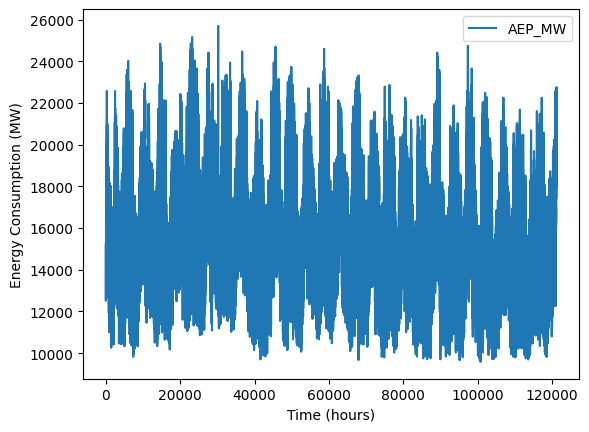

In [8]:
df.plot(xlabel="Time (hours)", ylabel="Energy Consumption (MW)")

<AxesSubplot: title={'center': 'Frequency of energy loads in MW'}, ylabel='Frequency'>

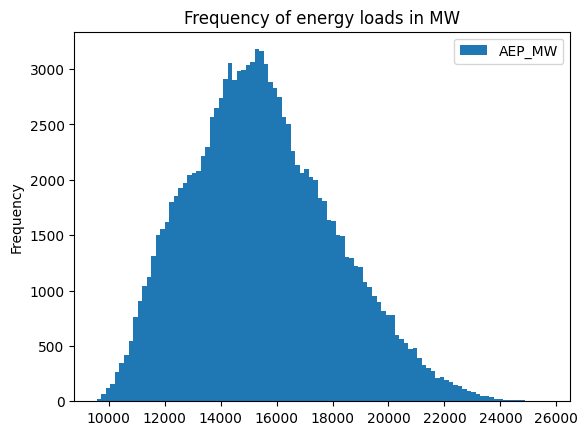

In [9]:
df.plot.hist(bins=100,title = "Frequency of energy loads in MW")

From these two graphs we can see the majority of hours under this regional grid are evenly distributed around 16000 MW of energy consumption however this various periodically throughout various time scales

## Part 1: RNN implementation
Now that we have a good idea of the data we are working with we can start building the RNN. The first step will be to do some additional time series transformations in order to capture the periodicity of the data. This will create a feature vector for time that can be combined with the energy consumption


In [10]:
# length of sequence that will  be used for prediction
seq_len = 20

# Feature engineering to exploid periodic nature of data
df['Datetime'] = pd.to_datetime(df['Datetime'])
hours = df["Datetime"].map(pd.Timestamp.timestamp)/3600
print(hours)
df["Day Sin"] = np.sin(hours * (2 * np.pi / 24))
df["Day Cos"] = np.cos(hours * (2 * np.pi / 24))

df["Week Sin"] = np.sin(hours * (2 * np.pi / 168))
df["Week Cos"] = np.cos(hours * (2 * np.pi / 168))

df["Month Sin"] = np.sin(hours * (2 * np.pi / 730))
df["Month Cos"] = np.cos(hours * (2 * np.pi / 730))
 
df["Year Sin"] = np.sin(hours * (2 * np.pi / 8760))
df["Year Cos"] = np.cos(hours * (2 * np.pi / 8760))

df.head()

0         306793.0
1         306794.0
2         306795.0
3         306796.0
4         306797.0
            ...   
121268    420788.0
121269    420789.0
121270    420790.0
121271    420791.0
121272    420792.0
Name: Datetime, Length: 121273, dtype: float64


,Datetime,AEP_MW,Day Sin,Day Cos,Week Sin,Week Cos,Month Sin,Month Cos,Year Sin,Year Cos
0,2004-12-31 01:00:00,13478.0,0.258819,0.965926,0.804598,0.593820,0.995919,-0.090252,0.137989,0.990434
1,2004-12-31 02:00:00,12865.0,0.500000,0.866025,0.826239,0.563320,0.995105,-0.098820,0.138700,0.990335
2,2004-12-31 03:00:00,12577.0,0.707107,0.707107,0.846724,0.532032,0.994218,-0.107381,0.139410,0.990235
3,2004-12-31 04:00:00,12517.0,0.866025,0.500000,0.866025,0.500000,0.993257,-0.115935,0.140120,0.990135
4,2004-12-31 05:00:00,12670.0,0.965926,0.258819,0.884115,0.467269,0.992222,-0.124479,0.140830,0.990034


Since energy use is highly periodic along various time scales part of the input feature to the sequential models will be a fourier transform on the input time.

Based on:
https://arxiv.org/pdf/2006.10739.pdf

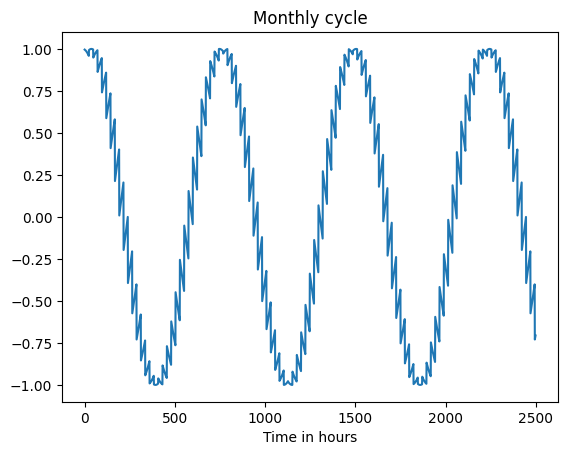

In [11]:
plt.plot(np.array(df['Month Sin'])[:2500])
plt.xlabel('Time in hours')
plt.title('Monthly cycle')
plt.show()

          AEP_MW   Day Sin   Day Cos  Week Sin  Week Cos  Month Sin  \
20     -0.490873 -0.999869  1.000219  1.405979 -0.158381   1.364641   
21     -0.614083 -0.706989  1.224972  1.399076 -0.210819   1.361433   
22     -0.833769 -0.365922  1.366257  1.390217 -0.262962   1.358125   
23     -1.060817  0.000088  1.414447  1.379415 -0.314738   1.354716   
24     -0.593936  0.366097  1.366257  0.053608  1.413253   1.403532   
...          ...       ...       ...       ...       ...        ...   
121268  2.115137 -1.224604  0.707317 -1.315653 -0.516725   0.665621   
121269  2.080267 -0.999869  1.000219 -1.334050 -0.467138   0.654866   
121270  2.010912 -0.706989  1.224972 -1.350581 -0.416897   0.644063   
121271  1.853994 -0.365922  1.366257 -1.365221 -0.366073   0.633212   
121272  1.690489  0.000088  1.414447 -1.377952 -0.314738   0.622315   

        Month Cos  Year Sin  Year Cos  
20      -0.368553  0.247909  1.387045  
21      -0.380302  0.248914  1.386890  
22      -0.392022  0.249919

<AxesSubplot: >

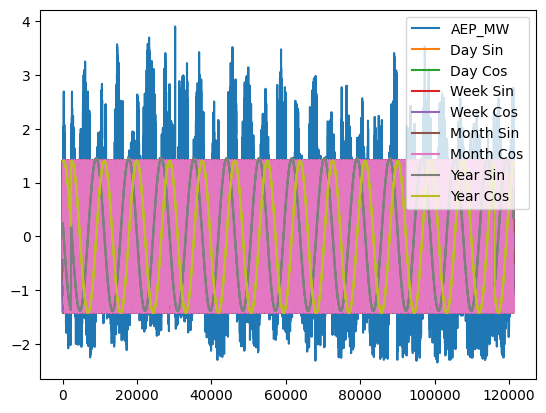

In [12]:
# For seq_len look back and T+1 hour look ahead prediction
def preprocess_data(frame):
    frame.describe()
    data = frame.to_numpy()
    print(data[20])
    print(data[21])
    look_back = seq_len
    X = []
    Y = []
    for i in range(look_back,data.shape[0]):
        X.append(data[i-look_back: i,:])
        Y.append(data[i,0])
        
    print(Y[0])
    print(Y[1])
    return np.asarray(X),np.asarray(Y)

# Normalizing energy data
samples = df.shape[0]
attributes = df.shape[1]-1

df_train = df[0:int(samples*0.8)].drop("Datetime",axis=1)
train_mean = df_train.mean()
train_std = df_train.std()

norm_df = (df.drop("Datetime",axis=1)-train_mean)/train_std
print(norm_df[20:])

X,Y = preprocess_data(norm_df)

# Doing a 80 10 10 split
x_train = X[0:int(samples*0.8)]
y_train = Y[0:int(samples*0.8)]

x_valid = X[int(samples*0.8):int(samples*0.9)]
y_valid = Y[int(samples*0.8):int(samples*0.9)]

x_test = X[int(samples*0.9):]
y_test = Y[int(samples*0.9):]

print(X.shape)
print(x_test.shape)
print(x_valid.shape)
print(x_train.shape)

train_mean = x_train.mean()
train_std = x_train.std()
norm_df.plot()

Text(0.5, 1.0, 'Prediction set example')

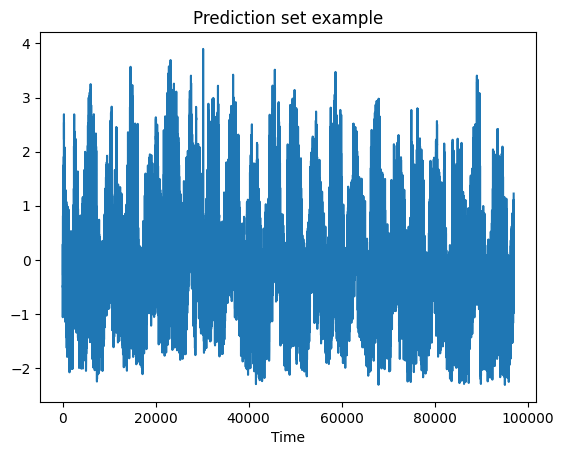

In [13]:
plt.plot(y_train)
plt.xlabel("Time")
plt.title("Prediction set example")

Here are the features visualized the normalized MW data and periodic functions derived from the date will be used to train the RNN. The second graph is an example of the values to predict

In [14]:
# Simple RNN based on tensorflow keras resources
rnn = Sequential()
rnn.add(SimpleRNN(64,activation="tanh",return_sequences=True, input_shape=(x_train.shape[1],9)))
rnn.add(Dropout(0.20))
rnn.add(SimpleRNN(64,activation="tanh",return_sequences=True))
rnn.add(Dropout(0.20))
rnn.add(SimpleRNN(64,activation="tanh",return_sequences=False))
rnn.add(Dropout(0.20))
rnn.add(Dense(units=1))
rnn.summary()

2022-10-23 22:17:24.521677: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-23 22:17:24.536413: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/cuda/lib64:/opt/cuda/lib64:
2022-10-23 22:17:24.536434: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-10-23 22:17:24.536951: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimi

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 20, 64)            4736      
                                                                 
 dropout (Dropout)           (None, 20, 64)            0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 20, 64)            8256      
                                                                 
 dropout_1 (Dropout)         (None, 20, 64)            0         
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 6

### RNN Model Details
For this RNN I decided on three RNN layers with 64 neurons each and tanh activation functions for all time steps and a bias term (implicitly declared see: https://www.tensorflow.org/api_docs/python/tf/keras/layers/SimpleRNN). Drop out was used to avoid overfitting since the sequence used for my training is extremely long and this form is generally kept the same throughout the various models being tested here. Finally a final linear FC layer is used to generate the output prediction of the next term in the sequence (energy consumption prediction for the next hour in MW). 

To measure the performance of this model I decided to go with mean squared error since this is a classic regression problem and the mean absolute error as a metric to more intuitively see how off the model's predictions are. This loss is paired with the Adam optimizaer and trained for 12 epochs with a large batch size of 1024 where each sample is a prediction task of predicting the next hour of energy consumption based on the previous 20 hours.

Epoch 1/12
95/95 [==============================] - 6s 54ms/step - loss: 0.3323 - mse: 0.3323 - mae: 0.4427 - val_loss: 0.0790 - val_mse: 0.0790 - val_mae: 0.2149
Epoch 2/12
95/95 [==============================] - 4s 45ms/step - loss: 0.1292 - mse: 0.1292 - mae: 0.2809 - val_loss: 0.0618 - val_mse: 0.0618 - val_mae: 0.1882
Epoch 3/12
95/95 [==============================] - 5s 52ms/step - loss: 0.0880 - mse: 0.0880 - mae: 0.2293 - val_loss: 0.0528 - val_mse: 0.0528 - val_mae: 0.1727
Epoch 4/12
95/95 [==============================] - 4s 46ms/step - loss: 0.0685 - mse: 0.0685 - mae: 0.1999 - val_loss: 0.0520 - val_mse: 0.0520 - val_mae: 0.1733
Epoch 5/12
95/95 [==============================] - 5s 50ms/step - loss: 0.0575 - mse: 0.0575 - mae: 0.1813 - val_loss: 0.0457 - val_mse: 0.0457 - val_mae: 0.1608
Epoch 6/12
95/95 [==============================] - 4s 45ms/step - loss: 0.0517 - mse: 0.0517 - mae: 0.1701 - val_loss: 0.0447 - val_mse: 0.0447 - val_mae: 0.1595
Epoch 7/12
95/95 [====

[]

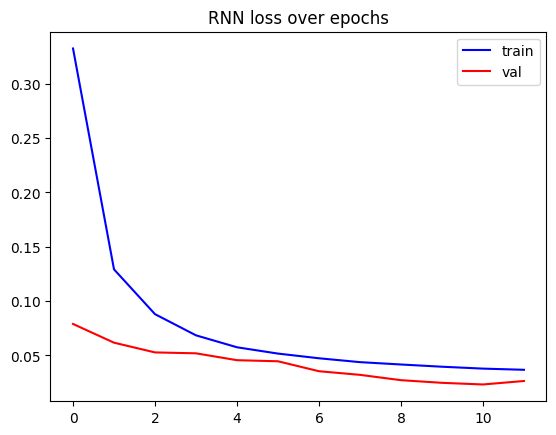

In [15]:
# Configuration and training
rnn.compile(optimizer="adam",loss="mse",metrics=["mse","mae"])
rnn_history = rnn.fit(x_train, y_train,validation_data=(x_valid, y_valid), epochs=12, batch_size=1024)
plt.plot(rnn_history.history["mse"],color="blue")
plt.plot(rnn_history.history["val_mse"],color="red")
plt.title("RNN loss over epochs")
plt.legend(['train', 'val'], loc='upper right')
plt.plot()

In [16]:
# Testing RNN model
from sklearn.metrics import r2_score
test_score = rnn.evaluate(x_test,y_test)
print(f"Test mse {test_score[0]} \t Test mae {test_score[1]}")
test_pred = rnn.predict(x_test)
print(f"R^2 fit on test data: {r2_score(y_test,test_pred):0.4f}")


379/379 [==============================] - 1s 3ms/step - loss: 0.0240 - mse: 0.0240 - mae: 0.1065
Test mse 0.02399265393614769 	 Test mae 0.02399265393614769
379/379 [==============================] - 1s 3ms/step
R^2 fit on test data: 0.9737


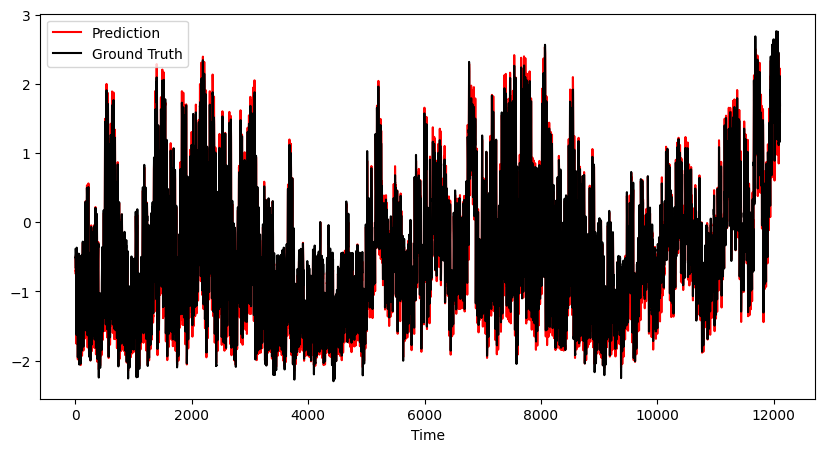

In [17]:
plt.figure(figsize=(10,5))
plt.plot(test_pred,color = "red",label ="Prediction")
plt.plot(y_test,color="black", label = "Ground Truth")
plt.xlabel("Time")
plt.legend()
plt.show()

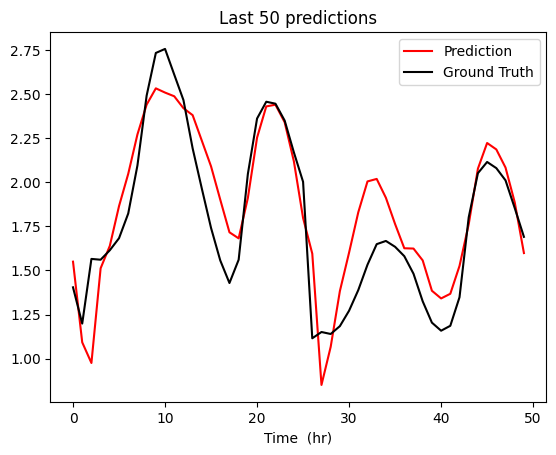

In [18]:
plt.plot(test_pred[-50:],color = "red",label ="Prediction")
plt.plot(y_test[-50:],color="black", label = "Ground Truth")
plt.legend()
plt.xlabel("Time  (hr)")
plt.title("Last 50 predictions")
plt.show()

## Analysis
From this we can see the RNN performed very well with a R^2 fit on the test data of 0.9737 and reasonable output from the graph's visualization of predictions and ground truth. The overall test and validation msa was lower then the training set indicating the RNN did not overfit which is also ideal. It is likely the RNN performed so well here due to the short prediction look ahead (1 hour) and extreme periodicity of the data (high signal to noise ratio).

## Part 2: LSTM and GRU

In [19]:
# LSTM architecture
lstm = Sequential()
lstm.add(LSTM(64, activation="tanh", return_sequences=True, input_shape=(x_train.shape[1],9)))
lstm.add(Dropout(0.10))
lstm.add(LSTM(64, activation="tanh", return_sequences=True))
lstm.add(Dropout(0.10))
lstm.add(LSTM(64, activation="tanh", return_sequences=False))
lstm.add(Dropout(0.10))
lstm.add(Dense(units=1))
# Implicitly recurrent_activation='sigmoid'
lstm.summary()
    

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 64)            18944     
                                                                 
 dropout_3 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 20, 64)            33024     
                                                                 
 dropout_4 (Dropout)         (None, 20, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

### LSTM Model Details
Largely similar to RNN for testing purposes with the following desc:
For this LSTM I decided on three LSTM layers with 64 neurons each and tanh activation functions for all time steps with a recurrent sigmoid activation and a bias term (implicitly declared see: https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM). Drop out was used to avoid overfitting but with a lower constant then the RNN since LSTMs can handle long term dependencies better then RNN and are less likely to immediatly overfit. Finally a final linear FC layer is used to generate the output prediction of the next term in the sequence (energy consumption prediction for the next hour in MW). 

Same as RNN: 
To measure the performance of this model I decided to go with mean squared error since this is a classic regression problem and the mean absolute error as a metric to more intuitively see how off the model's predictions are. This loss is paired with the Adam optimizaer and trained for 12 epochs with a large batch size of 1024 where each sample is a prediction task of predicting the next hour of energy consumption based on the previous 20 hours.

I anticipate the LSTM to perform better then the RNN due to it's gate based design ability to better represent the long input sequence (20) without exploding or vanishing gradients.

Epoch 1/12
95/95 [==============================] - 16s 135ms/step - loss: 0.2098 - mse: 0.2098 - mae: 0.3405 - val_loss: 0.1006 - val_mse: 0.1006 - val_mae: 0.2365
Epoch 2/12
95/95 [==============================] - 12s 128ms/step - loss: 0.0764 - mse: 0.0764 - mae: 0.2102 - val_loss: 0.0583 - val_mse: 0.0583 - val_mae: 0.1770
Epoch 3/12
95/95 [==============================] - 13s 136ms/step - loss: 0.0552 - mse: 0.0552 - mae: 0.1773 - val_loss: 0.0444 - val_mse: 0.0444 - val_mae: 0.1514
Epoch 4/12
95/95 [==============================] - 13s 132ms/step - loss: 0.0447 - mse: 0.0447 - mae: 0.1576 - val_loss: 0.0367 - val_mse: 0.0367 - val_mae: 0.1363
Epoch 5/12
95/95 [==============================] - 13s 135ms/step - loss: 0.0384 - mse: 0.0384 - mae: 0.1449 - val_loss: 0.0311 - val_mse: 0.0311 - val_mae: 0.1237
Epoch 6/12
95/95 [==============================] - 13s 135ms/step - loss: 0.0336 - mse: 0.0336 - mae: 0.1347 - val_loss: 0.0256 - val_mse: 0.0256 - val_mae: 0.1090
Epoch 7/12

[]

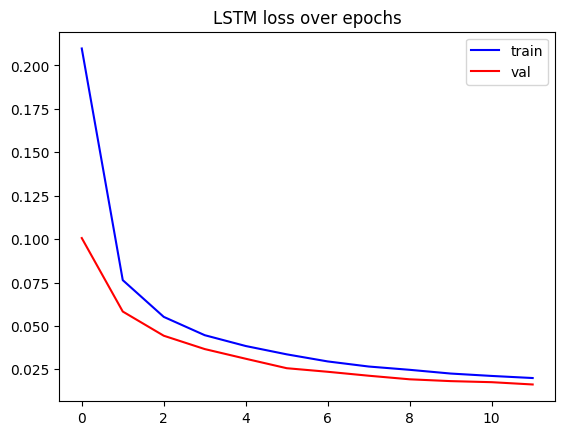

In [20]:
# Configuration and training
lstm.compile(optimizer="adam",loss="mse",metrics=["mse","mae"])
lstm_history = lstm.fit(x_train, y_train,validation_data=(x_valid, y_valid), epochs=12, batch_size=1024)
plt.plot(lstm_history.history["mse"],color="blue")
plt.plot(lstm_history.history["val_mse"],color="red")
plt.title("LSTM loss over epochs")
plt.legend(['train', 'val'], loc='upper right')
plt.plot()

In [21]:
# Testing LSTM model
from sklearn.metrics import r2_score
test_score = lstm.evaluate(x_test,y_test)
print(f"Test mse {test_score[0]} \t Test mae {test_score[1]}")
lstm_test_pred = lstm.predict(x_test)
print(f"R^2 fit on test data: {r2_score(y_test,lstm_test_pred):0.4f}")

379/379 [==============================] - 2s 6ms/step - loss: 0.0147 - mse: 0.0147 - mae: 0.0751
Test mse 0.01466312911361456 	 Test mae 0.01466312911361456
379/379 [==============================] - 3s 5ms/step
R^2 fit on test data: 0.9839


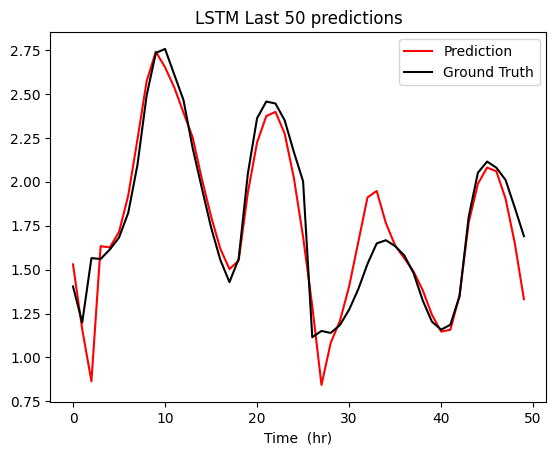

In [22]:
plt.plot(lstm_test_pred[-50:],color = "red",label ="Prediction")
plt.plot(y_test[-50:],color="black", label = "Ground Truth")
plt.legend()
plt.xlabel("Time  (hr)")
plt.title("LSTM Last 50 predictions")
plt.show()

### LSTM results
The LSTM outperformed the RNN as expected with and R^2 score on the test set of 0.9839 and a closer fit to the example curve above. This is expected for two reasons. This base design has more parameters then the RNN due to the LSTM's gates and thus more memory capacity and secondly the LSTM with it's input, forget, and output gates is able to decide which data from the previous 20 hours should be sent forwards to the final prediction. Since the feature encoding has redundent information (each sample is largly within the same year or month) this helps prevent unnessesary data from propagating forwards.
### Now attempting GRU

In [23]:
# GRU architecture
gru = Sequential()
gru.add(GRU(64, activation="tanh", return_sequences=True, input_shape=(x_train.shape[1],9)))
gru.add(Dropout(0.15))
gru.add(GRU(64, activation="tanh", return_sequences=True))
gru.add(Dropout(0.15))
gru.add(GRU(64, activation="tanh", return_sequences=False))
gru.add(Dropout(0.15))
gru.add(Dense(units=1))
# Implicitly recurrent_activation='sigmoid'
gru.summary()
    

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 20, 64)            14400     
                                                                 
 dropout_6 (Dropout)         (None, 20, 64)            0         
                                                                 
 gru_1 (GRU)                 (None, 20, 64)            24960     
                                                                 
 dropout_7 (Dropout)         (None, 20, 64)            0         
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                

### GRU model details
Same as the LSTM (see above) with tanh activation for input and sigmoid between gates. The only difference is the GRU has a higher drop-out of .15 then the LSTM to test the difference in overfitting.

Epoch 1/12
95/95 [==============================] - 15s 123ms/step - loss: 0.1656 - mse: 0.1656 - mae: 0.3008 - val_loss: 0.0488 - val_mse: 0.0488 - val_mae: 0.1626
Epoch 2/12
95/95 [==============================] - 11s 114ms/step - loss: 0.0623 - mse: 0.0623 - mae: 0.1910 - val_loss: 0.0374 - val_mse: 0.0374 - val_mae: 0.1411
Epoch 3/12
95/95 [==============================] - 11s 115ms/step - loss: 0.0504 - mse: 0.0504 - mae: 0.1698 - val_loss: 0.0310 - val_mse: 0.0310 - val_mae: 0.1246
Epoch 4/12
95/95 [==============================] - 11s 118ms/step - loss: 0.0427 - mse: 0.0427 - mae: 0.1544 - val_loss: 0.0268 - val_mse: 0.0268 - val_mae: 0.1134
Epoch 5/12
95/95 [==============================] - 11s 120ms/step - loss: 0.0369 - mse: 0.0369 - mae: 0.1414 - val_loss: 0.0236 - val_mse: 0.0236 - val_mae: 0.1026
Epoch 6/12
95/95 [==============================] - 12s 123ms/step - loss: 0.0328 - mse: 0.0328 - mae: 0.1310 - val_loss: 0.0216 - val_mse: 0.0216 - val_mae: 0.0937
Epoch 7/12

[]

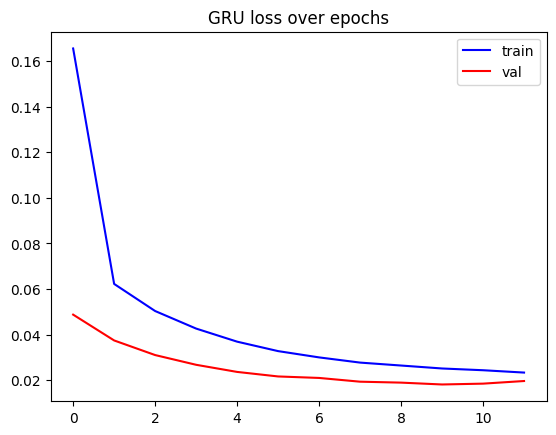

In [24]:
# Configuration and training
gru.compile(optimizer="adam",loss="mse",metrics=["mse","mae"])
gru_history = gru.fit(x_train, y_train,validation_data=(x_valid, y_valid), epochs=12, batch_size=1024)
plt.plot(gru_history.history["mse"],color="blue")
plt.plot(gru_history.history["val_mse"],color="red")
plt.title("GRU loss over epochs")
plt.legend(['train', 'val'], loc='upper right')
plt.plot()

In [25]:
# Testing GRU model
from sklearn.metrics import r2_score
test_score = gru.evaluate(x_test,y_test)
print(f"Test mse {test_score[0]} \t Test mae {test_score[1]}")
gru_test_pred = lstm.predict(x_test)
print(f"R^2 fit on test data: {r2_score(y_test,gru_test_pred):0.4f}")

379/379 [==============================] - 2s 4ms/step - loss: 0.0178 - mse: 0.0178 - mae: 0.0841
Test mse 0.0178484246134758 	 Test mae 0.0178484246134758
379/379 [==============================] - 2s 5ms/step
R^2 fit on test data: 0.9839


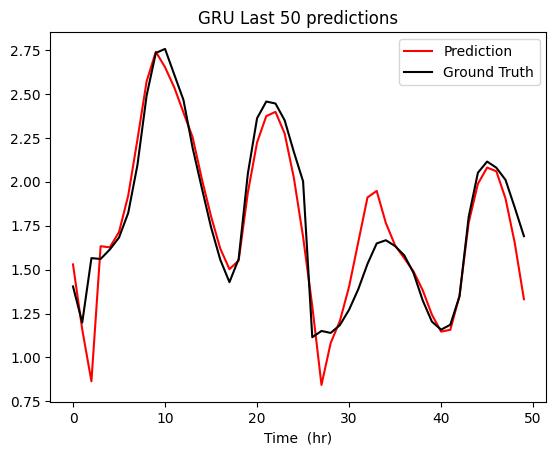

In [26]:
plt.plot(gru_test_pred[-50:],color = "red",label ="Prediction")
plt.plot(y_test[-50:],color="black", label = "Ground Truth")
plt.legend()
plt.xlabel("Time  (hr)")
plt.title("GRU Last 50 predictions")
plt.show()

### GRU Results
The GRU performed similar to the LSTM with an R^2 of 0.9839 and slightly different fitting characteristics (but still close fitting) on the test set. This similar performance is likely due to the same ability of the GRU to disregard data through it's reset gate and update gate. Major differences between GRU and LSTM probably do not become apparent on this dataset due to it's ease of modeling with a short lookahead and predictable pattern.

### RNN vs GRU vs LSTM Analysis
Overall, all three models performed well on this dataset and would make acceptable predictors for energy consumption. The gate based models of the GRU and LSTM noticebly helped them acheive higher generalizability with better fits on the validation and test datasets however the ease of modeling revealed these two model's similar characteristics on this dataset. I beleive this ease of fitting was due to the relatively short lookahead of one hour which does not truely test the difference in the LSTM and GRU's gate models ability to handle vanishing or exploding gradients and information loss. Despite this from the loss graphs we can see the GRU and LSTM's both had slightly faster convergence implying a better model. The two gate design on the GRU and three gate design of the LSTM both designed for handling longer sequences with more noise helped them gain an edge on the RNN with the ability to ignore some of the redundent data (period functions for time repeat often in the sequence). However, these additional gates also meant these two models had higher parameter counts and longer runtimes. The RNN is unable to ignore the data repetition and thus it has to factor it in for every time step potentially wasting parameters on this input function that could simply ignore the term after the first input. For this problem I would likely choose the GRU or RNN due to their high accuracy and lower parameter count then the LSTM which makes sense since they both have simpler architectures. This is one of the cases where a simpler model is preferable since it can efficiently meet the demands of the problem (RNN). The LSTM and GRU may perform better if the sequence length look ahead and look behind was increased. It is also important to note that the different fitting characteristics of the GRU and LSTM should be looked at in further considering these models since even though their fits were similar they may have slightly different biases or failure conditions which may be important in the real world.

## Part 3: How feed-forward networks could be applied to solve this problem.
In it's current formulation feed forward networks could be easily applied to solve this problem. While RNN, GRU, and LSTMs can be flexible on sequence input size and process sequences of various lengths to consider long chains of dependence, simple feed-forward networks have fixed input lengths. Since in this example I only trained models with sequence lengths of 20 (could very if desired for these models) I could directly apply this model to a fixed NN. This would be done by taking the previous 20 samples in the sequence and feeding it to the input of a feed-foward model that predicts the value for the next hour. This method is actually used on sequence data with some convulutional neural networks as a preprocessing step to sequential models like RNN or transformers. With this 20 hour look behind for a T+1 hour look ahead prediction the network could easily be intergrated but not without consequences. Since the sequnce is being processed all at once and not one after the other the model is unable to "reuse" parameters through repeated updates with the origional sequence.  Whatever relationship between the input sequence the NN would model would be fixxed and the model would be unable to consider longer sequences or states in it's prediction while having to rely on a single inference to make it's prediction rather then multiple severly reducing the model's dynamic ability. Consider a Feed forward network vs a RNN learning to curve fit a sine wave. The RNN could easily infer the next value based a few input samples since it's not creating fixed dependencies on the order of its sequence but the feed forward network would be forced to "align" the sign wave implicitly (set up a complex relationship between all inputs regardless of start and end point) to generate its prediction.

Overall, while feed-forwad networks could technically be applied to this problem it is not ideal for time series data.

# Task 2: Word Embeddings
Starting with the Wor2vec embedding to create a function that measures the similarity and difference between two words.

For my dissimilarty score I decided that 1-cos_similarity makes sense since cos_similarity is measuring the angle between two word vectors and the higher the angle is between them the more negative the similarity score would  be and thus 1-similarity would be greater which follows our expectations of the relationship between similarity and dissimilarity. Essentially the angle between these pretrained vector embeddings is how we will measure the similarity of words with a lower angle (alignment) implying similarity and opposite angles (complements) indicate dissimilarity. Along with this other metrics such as euclidean distance would not properly co-respond with the cos based similarity since the angle between two vectors does not change based on their magntitudes and that is the same with my dissimilarity score. This idea is discussed further in this paper:

https://dl.acm.org/doi/abs/10.1145/1376815.1376819?casa_token=QbSgnnb25N4AAAAA%3AQPJYMoh_zQ5Oh0iYmGbCO7dQAlsJVTU8-VUvv0P4zzozmxnWxRvNs-vv-6ZatDjciOWrYdv4bsRs

Using pretrained word vectors from gensim: glove-wiki-gigaword-100 found here https://radimrehurek.com/gensim/models/keyedvectors.html

In [27]:
import gensim
import gensim.downloader as gda
# Word vectors that whose distance will be compared
word_vecs = gda.load("glove-wiki-gigaword-100")


In [34]:
# vector cosine similarity
def cos_similarity(a,b):
    return np.dot(a,b)/(np.linalg.norm(a)*np.linalg.norm(b))

def test_user_word_pair(word_vecs):
    x = input("Enter Word 1:").strip()
    y = input("Enter Word 2:").strip()
    similarity_angle = cos_similarity(word_vecs[x],word_vecs[y])
    print(f"The Cosine Similarity of ({x}) and ({y}) is {similarity_angle}")
    # Dissimilarity defined below as 1-cosine similarity
    print(f"The Disimilarity of ({x}) and ({y}) is {1-similarity_angle}")

In [29]:
test_user_word_pair(word_vecs)

Enter Word 1: dress
Enter Word 2: pants


The Cosine Similarity of (dress) and (pants) is 0.7403673529624939
The Disimilarity of (dress) and (pants) is 0.2596326470375061


In [30]:
test_user_word_pair(word_vecs)

Enter Word 1: dog
Enter Word 2: cat


The Cosine Similarity of (dog) and (cat) is 0.8798075914382935
The Disimilarity of (dog) and (cat) is 0.12019240856170654


In [31]:
test_user_word_pair(word_vecs)

Enter Word 1: puke
Enter Word 2: rain


The Cosine Similarity of (puke) and (rain) is -0.10829438269138336
The Disimilarity of (puke) and (rain) is 1.1082943826913834


In [32]:
test_user_word_pair(word_vecs)

Enter Word 1: pink
Enter Word 2: truck


The Cosine Similarity of (pink) and (truck) is 0.18172141909599304
The Disimilarity of (pink) and (truck) is 0.818278580904007


In [33]:
test_user_word_pair(word_vecs)

Enter Word 1: otter
Enter Word 2: bear


The Cosine Similarity of (otter) and (bear) is 0.4018262028694153
The Disimilarity of (otter) and (bear) is 0.5981737971305847


### Analysis
From these tests we can see this pretrained vector embedding and cosine similarity is a simple but effective method in telling how related two words are. The first example of dress and pants received a high similarity score as they are both articles of clothing as well as dog and cat since they are both animals. On the flip side, puke and rain, and pink and truck scored high in the dissimilarity score as these concepts are not related or commonly associated directly (although some trucks can be described as pink). For the last test of otters and bears it was split down the middle leaning towards dissimilar which personally makes less sense to me as they are both hairy animals but they are of different species. Overall, this method is useful for it's ease of use and simple implementation since it provides a reasonable sepration of similar and through my custom function of 1-cos, dissimilar words.

Have a great day!